In [1]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_score
import numpy as np
import csv
from sklearn.datasets.base import Bunch
import pickle
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV

from mlxtend.plotting import plot_confusion_matrix

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Feature engineering

In [2]:
train_filepath = 'data/train.csv'
traindata = pd.read_table(train_filepath,sep="\t")
traindata.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,9938,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP04,1,R1C1,2005-09-09 12:23:34.0,2005-09-09 12:24:07.0,2005-09-09 12:24:07.0,2005-09-09 12:24:07.0,33.0,33.0,NaN,1,0,0,1,NaN,NaN
1,9939,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP04,1,R1C2,2005-09-09 12:24:07.0,2005-09-09 12:24:22.0,2005-09-09 12:24:22.0,2005-09-09 12:24:22.0,15.0,15.0,NaN,1,0,0,1,NaN,NaN
2,9940,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP04,1,R3C1,2005-09-09 12:24:22.0,2005-09-09 12:25:16.0,2005-09-09 12:25:40.0,2005-09-09 12:25:40.0,78.0,NaN,78.0,0,2,0,1,Define Variable,1
3,9941,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP04,1,R3C2,2005-09-09 12:25:40.0,2005-09-09 12:25:51.0,2005-09-09 12:27:24.0,2005-09-09 12:27:24.0,104.0,NaN,104.0,0,4,9,1,"Using small numbers~~Write expression, positiv...",1~~1~~1
4,9942,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP04,1,R4C1,2005-09-09 12:27:24.0,2005-09-09 12:27:30.0,2005-09-09 12:27:30.0,2005-09-09 12:27:30.0,6.0,6.0,NaN,1,0,0,1,Entering a given,1


## Split the feature 'problem hierarchy' into 'Units' and 'Sections'

In [3]:
hierarchy = traindata['Problem Hierarchy']
units, sections = [], []
for i in range(len(hierarchy)):
    units.append(hierarchy[i].split(',')[0].strip())
    sections.append(hierarchy[i].split(',')[1].strip())
    
# Now add 'Units' and 'Sections' as columns within the dataframe
traindata['Problem Unit'] = pd.Series(units, index=traindata.index)
traindata['Problem Section'] = pd.Series(sections, index=traindata.index)

cols = traindata.columns.tolist()
cols = cols[0:3]+cols[-2::]+cols[3:-2]
traindata = traindata[cols]

In [4]:
traindata = traindata[['Anon Student Id','Problem Hierarchy','Problem Unit','Problem Section','Problem Name','Problem View','Step Name','Correct First Attempt','KC(Default)','Opportunity(Default)']]
traindata.head()

,Anon Student Id,Problem Hierarchy,Problem Unit,Problem Section,Problem Name,Problem View,Step Name,Correct First Attempt,KC(Default),Opportunity(Default)
0,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",Unit CTA1_13,Section CTA1_13-1,PROP04,1,R1C1,1,NaN,NaN
1,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",Unit CTA1_13,Section CTA1_13-1,PROP04,1,R1C2,1,NaN,NaN
2,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",Unit CTA1_13,Section CTA1_13-1,PROP04,1,R3C1,0,Define Variable,1
3,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",Unit CTA1_13,Section CTA1_13-1,PROP04,1,R3C2,0,"Using small numbers~~Write expression, positiv...",1~~1~~1
4,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",Unit CTA1_13,Section CTA1_13-1,PROP04,1,R4C1,1,Entering a given,1


## Encoding Categorical Features
Since the model can not read in text data, so we need to categorical text data into model-understandable numerical data. Here we choose to use the Label Encoder class.

In [5]:
Labelized_data = traindata.copy(deep=True)

le_Sid = preprocessing.LabelEncoder()
le_PH = preprocessing.LabelEncoder()
le_PN = preprocessing.LabelEncoder()
le_PV = preprocessing.LabelEncoder()
le_SN = preprocessing.LabelEncoder()
le_PU = preprocessing.LabelEncoder()
le_PS = preprocessing.LabelEncoder()
le_KC = preprocessing.LabelEncoder()
le_OP = preprocessing.LabelEncoder()


le_Sid.fit(traindata['Anon Student Id'])
Labelized_data['Anon Student Id'] = le_Sid.transform(Labelized_data['Anon Student Id']) 

le_PH.fit(traindata['Problem Hierarchy'])
Labelized_data['Problem Hierarchy'] = le_PH.transform(Labelized_data['Problem Hierarchy']) 

le_PN.fit(traindata['Problem Name'])
Labelized_data['Problem Name'] = le_PN.transform(Labelized_data['Problem Name']) 

le_SN.fit(traindata['Step Name'])
Labelized_data['Step Name'] = le_SN.transform(Labelized_data['Step Name']) 

le_PU.fit(traindata['Problem Unit'])
Labelized_data['Problem Unit'] = le_PU.transform(Labelized_data['Problem Unit']) 

le_PS.fit(traindata['Problem Section'])
Labelized_data['Problem Section'] = le_PS.transform(Labelized_data['Problem Section']) 

#le_KC.fit(traindata['KC(Default)'])
#Labelized_data['KC(Default)'] = le_KC.transform(Labelized_data['KC(Default)']) 

#le_OP.fit(traindata['Opportunity(Default)'])
#Labelized_data['Opportunity(Default)'] = le_OP.transform(Labelized_data['Opportunity(Default)']) 


In [6]:
Labelized_data.head()

,Anon Student Id,Problem Hierarchy,Problem Unit,Problem Section,Problem Name,Problem View,Step Name,Correct First Attempt,KC(Default),Opportunity(Default)
0,29,32,7,32,759,1,53491,1,NaN,NaN
1,29,32,7,32,759,1,53492,1,NaN,NaN
2,29,32,7,32,759,1,53497,0,Define Variable,1
3,29,32,7,32,759,1,53498,0,"Using small numbers~~Write expression, positiv...",1~~1~~1
4,29,32,7,32,759,1,53500,1,Entering a given,1


## Since the given dataset traindata.csv is unbalanced, create sample weight for "fit"

In [7]:
sample_w =[]

for ind in traindata.index: 
    if traindata['Correct First Attempt'][ind] == 1:
        sample_w.append(1)
    else:
        sample_w.append(3.56)


## Build heatmap for finding the correlation of each feature and "Correct First Attempt"

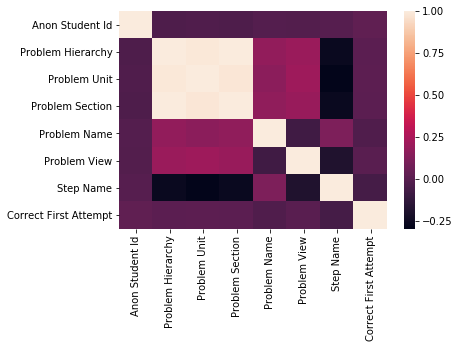

In [8]:
import seaborn as sns

sns.heatmap(Labelized_data.corr())

## Select the encoded data as x_train and y_train.

In [9]:
from sklearn.model_selection import train_test_split

x_train = Labelized_data[['Anon Student Id','Problem Name','Step Name','Problem Hierarchy','Problem View','Problem Unit','Problem Section']]
y_train= Labelized_data['Correct First Attempt']

#x_train.shape #(232744, 5)
#y_train.shape  #(232744, 1)

## Choose the model

### 1.Use random forest classifier as ensemble meta-estimator. It can reduce the variance of a black-box estimator , by introducing randomization into its construction procedure and then making an ensemble out of it.

### 2.To improve the performance of model, Use GridSearchCV to do a exhaustive search over specified parameter values to tune hyperparameters for Random forest classifier.(eg. n_estimators, max_depth and 'max_features')


In [10]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

x_train = Labelized_data[['Anon Student Id','Problem Name','Step Name','Problem Hierarchy','Problem View','Problem Unit','Problem Section']]
y_train= Labelized_data['Correct First Attempt']



param_grid = {
    'n_estimators' : [100,200,500],          
    'max_depth' : [x for x in range(1,1000,10)],
    'max_features': [1,2,4,6]
    
} 

rf = RandomForestClassifier()

clf = GridSearchCV(rf,
                   param_grid, scoring = 'neg_mean_squared_error')

clf.fit(x_train, y_train,sample_weight = sample_w)




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
print (clf.best_params_)


# Test


In [11]:
test_filepath = 'data/test.csv'
testdata = pd.read_table(test_filepath,sep="\t")

## Select samples from test.csv that 'Correct First Attempt' value is not NaN as test data to compute RMSE

In [12]:
# 取correct first attempt 不为空的行（sample）
test_data = testdata.copy(deep=True)
tmp = []
for i in range(1140):
    if test_data.loc[[i],['Correct First Attempt']].isnull().bool():
        tmp.append(i)
        
test_data.drop(test_data.index[[tmp]], inplace=True)

In [13]:
test_data = test_data.reset_index(drop=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 19 columns):
Row                            666 non-null int64
Anon Student Id                666 non-null object
Problem Hierarchy              666 non-null object
Problem Name                   666 non-null object
Problem View                   666 non-null int64
Step Name                      666 non-null object
Step Start Time                0 non-null float64
First Transaction Time         0 non-null float64
Correct Transaction Time       0 non-null float64
Step End Time                  0 non-null float64
Step Duration (sec)            0 non-null float64
Correct Step Duration (sec)    0 non-null float64
Error Step Duration (sec)      0 non-null float64
Correct First Attempt          666 non-null float64
Incorrects                     0 non-null float64
Hints                          0 non-null float64
Corrects                       0 non-null float64
KC(Default)                    494 non-

## Split the feature 'problem hierarchy' into 'Units' and 'Sections'

In [14]:
hierarchy = test_data['Problem Hierarchy']

units, sections = [], []
for i in range(len(hierarchy)):
    units.append(hierarchy[i].split(',')[0].strip())
    sections.append(hierarchy[i].split(',')[1].strip())
    
# Now add 'Units' and 'Sections' as columns within the dataframe
test_data['Problem Unit'] = pd.Series(units, index=test_data.index)
test_data['Problem Section'] = pd.Series(sections, index=test_data.index)

cols = test_data.columns.tolist()
cols = cols[0:3]+cols[-2::]+cols[3:-2]
test_data = test_data[cols]

In [15]:
test_data.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Unit,Problem Section,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,...,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,21616,8o0mJnIpFH,"Unit CTA1_06, Section CTA1_06-3",Unit CTA1_06,Section CTA1_06-3,JAN05,2,R5C1,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Using simple numbers~~Using large numbers~~Fin...,24~~15~~18
1,22178,8o0mJnIpFH,"Unit ES_03, Section ES_03-6",Unit ES_03,Section ES_03-6,EG51A,2,constant termsR2,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,22320,8o0mJnIpFH,"Unit CTA1_08, Section CTA1_08-2",Unit CTA1_08,Section CTA1_08-2,FEB03,1,yMin,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Changing axis bounds,98
3,22862,8o0mJnIpFH,"Unit ES_04, Section ES_04-15",Unit ES_04,Section ES_04-15,LIT58,1,7+y*(b+n) = r+f,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[SkillRule: Eliminate Parens; {CLT nested; CLT...,70
4,23277,8o0mJnIpFH,"Unit CTA1_10, Section CTA1_10-5",Unit CTA1_10,Section CTA1_10-5,DISTFB08_SP,1,R3C2,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,"Using simple numbers~~Write expression, positi...",78~~45~~56


## Transform the testdata into numeric data with corresponding LabelEncoder() of each features in train data.

In [16]:
x_test = test_data[['Anon Student Id','Problem Name','Step Name','Problem View','Problem Hierarchy','Problem Unit','Problem Section']]

test_data['Anon Student Id'] = test_data['Anon Student Id'].map(lambda s: '<unknown>' if s not in le_Sid.classes_ else s)
le_Sid.classes_ = np.append(le_Sid.classes_, '<unknown>')
x_test['Anon Student Id'] = le_Sid.transform(test_data['Anon Student Id'])

test_data['Problem Hierarchy'] = test_data['Problem Hierarchy'].map(lambda s: '<unknown>' if s not in le_PH.classes_ else s)
le_PH.classes_ = np.append(le_PH.classes_, '<unknown>')
x_test['Problem Hierarchy'] =le_PH.transform(test_data['Problem Hierarchy'])

test_data['Problem Name'] = test_data['Problem Name'].map(lambda s: '<unknown>' if s not in le_PN.classes_ else s)
le_PN.classes_ = np.append(le_PN.classes_, '<unknown>')
x_test['Problem Name'] = le_PN.transform(test_data['Problem Name']) 


test_data['Step Name'] = test_data['Step Name'].map(lambda s: '<unknown>' if s not in le_SN.classes_ else s)
le_SN.classes_ = np.append(le_SN.classes_, '<unknown>')
x_test['Step Name'] = le_SN.transform(test_data['Step Name'],) 

test_data['Problem Unit'] = test_data['Problem Unit'].map(lambda s: '<unknown>' if s not in le_PU.classes_ else s)
le_PU.classes_ = np.append(le_PU.classes_, '<unknown>')
x_test['Problem Unit'] = le_PU.transform(test_data['Problem Unit'],) 


test_data['Problem Section'] = test_data['Problem Section'].map(lambda s: '<unknown>' if s not in le_PS.classes_ else s)
le_PS.classes_ = np.append(le_PS.classes_, '<unknown>')
x_test['Problem Section'] = le_PS.transform(test_data['Problem Section'],) 

y_test = test_data['Correct First Attempt']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

## Using RandomForestClassifier as learning model, compute results and evaluate the model.

- ### compute RMSE and AUC scores
- ### plot Confusion matrix 
- ### print Classification Report




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


=== RMSE ===
0.5198752449100363
=== Confusion Matrix ===
[[ 20 106]
 [ 11 529]]
=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.30      0.33      0.32       126
         1.0       0.84      0.82      0.83       540

    accuracy                           0.73       666
   macro avg       0.57      0.58      0.57       666
weighted avg       0.74      0.73      0.73       666

=== All AUC Scores ===
[0.67797887 0.65948338 0.60138151 0.65516279 0.66472209]
=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6517457282546174


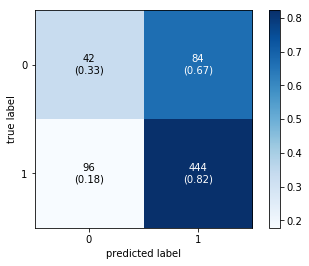

In [21]:
rfc = RandomForestClassifier()

rfc.fit(x_train,y_train)
rfc_predict = rfc.predict(x_test)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

rfc_cv_score = cross_val_score(rfc, x_train, y_train, cv=5, scoring='roc_auc')

print("=== RMSE ===")
print(np.sqrt(mean_squared_error(rfc_predict,y_test.values)))
#print('\n')

print("=== Confusion Matrix ===")

print(cm)


#print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
#print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
#print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())


cm = confusion_matrix(y_test, rfc_predict)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


## Using Using improved RandomForestClassifier with tuned hyperparameters, compute results and evaluate the model.

- ### compute RMSE and AUC scores
- ### plot Confusion matrix 
- ### print Classification Report




=== RMSE ===
0.4191368221424547


=== Confusion Matrix ===
[[ 20 106]
 [ 11 529]]
=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.65      0.16      0.25       126
         1.0       0.83      0.98      0.90       540

    accuracy                           0.82       666
   macro avg       0.74      0.57      0.58       666
weighted avg       0.80      0.82      0.78       666

=== All AUC Scores ===
[0.72254461 0.7208864  0.60706154 0.70831156 0.72587567]
=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6969359563806522


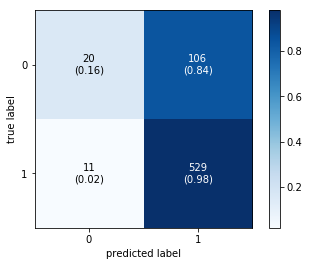

In [18]:
rfc = RandomForestClassifier(max_depth = 10, max_features = 6, n_estimators = 150)

rfc.fit(x_train,y_train,sample_weight = None)
rfc_predict = rfc.predict(x_test)

rfc_cv_score = cross_val_score(rfc, x_train, y_train, cv=5, scoring='roc_auc')


print("=== RMSE ===")
print(np.sqrt(mean_squared_error(rfc_predict,y_test.values)))
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
#print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
#print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
#print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())



cm = confusion_matrix(y_test, rfc_predict)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

#plt.savefig('rf_confusion_matrix.png', dpi=800)

## Read in testdata.csv. 
## Process and label testdata.

In [19]:

whole_test_data = testdata.copy(deep=True)

hierarchy = whole_test_data['Problem Hierarchy']

units, sections = [], []
for i in range(len(hierarchy)):
    units.append(hierarchy[i].split(',')[0].strip())
    sections.append(hierarchy[i].split(',')[1].strip())
    
# Now add 'Units' and 'Sections' as columns within the dataframe
whole_test_data['Problem Unit'] = pd.Series(units, index=whole_test_data.index)
whole_test_data['Problem Section'] = pd.Series(sections, index=whole_test_data.index)

cols = whole_test_data.columns.tolist()
cols = cols[0:3]+cols[-2::]+cols[3:-2]
whole_test_data = whole_test_data[cols]

whole_x_test = whole_test_data[['Anon Student Id','Problem Name','Step Name','Problem View','Problem Hierarchy','Problem Unit','Problem Section']]

whole_test_data['Anon Student Id'] = whole_test_data['Anon Student Id'].map(lambda s: '<unknown>' if s not in le_Sid.classes_ else s)
le_Sid.classes_ = np.append(le_Sid.classes_, '<unknown>')
whole_x_test['Anon Student Id'] = le_Sid.transform(whole_test_data['Anon Student Id'])

whole_test_data['Problem Hierarchy'] = whole_test_data['Problem Hierarchy'].map(lambda s: '<unknown>' if s not in le_PH.classes_ else s)
le_PH.classes_ = np.append(le_PH.classes_, '<unknown>')
whole_x_test['Problem Hierarchy'] =le_PH.transform(whole_test_data['Problem Hierarchy'])

whole_test_data['Problem Name'] = whole_test_data['Problem Name'].map(lambda s: '<unknown>' if s not in le_PN.classes_ else s)
le_PN.classes_ = np.append(le_PN.classes_, '<unknown>')
whole_x_test['Problem Name'] = le_PN.transform(whole_test_data['Problem Name']) 


whole_test_data['Step Name'] = whole_test_data['Step Name'].map(lambda s: '<unknown>' if s not in le_SN.classes_ else s)
le_SN.classes_ = np.append(le_SN.classes_, '<unknown>')
whole_x_test['Step Name'] = le_SN.transform(whole_test_data['Step Name'],) 

whole_test_data['Problem Unit'] = whole_test_data['Problem Unit'].map(lambda s: '<unknown>' if s not in le_PU.classes_ else s)
le_PU.classes_ = np.append(le_PU.classes_, '<unknown>')
whole_x_test['Problem Unit'] = le_PU.transform(whole_test_data['Problem Unit'],) 


whole_test_data['Problem Section'] = whole_test_data['Problem Section'].map(lambda s: '<unknown>' if s not in le_PS.classes_ else s)
le_PS.classes_ = np.append(le_PS.classes_, '<unknown>')
whole_x_test['Problem Section'] = le_PS.transform(whole_test_data['Problem Section'],) 

whole_y_test = whole_test_data['Correct First Attempt']

whole_test_data.shape

Predict = rfc.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

## Apply the model and do the prediction.
## Fill the 'Correct First Attempt' value of samples in testdata which has a Nan

In [20]:
Predict = rfc.predict(whole_x_test)

final = testdata.copy(deep=True)
final['Correct First Attempt'] = Predict;

for ind in tqdm(final.index): 
    if ind in tmp:
        pass
    else:  #从预测值回到给定值
        if testdata['Correct First Attempt'][ind] is not np.nan:
            final['Correct First Attempt'][ind] = testdata['Correct First Attempt'][ind]
        else:
            print("pipipipipip")
#testdata.head()  




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


## Wirte to the csv file.

In [ ]:
final.info()

export_csv = final.to_csv (r'\Desktop\export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
